In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to BanglaLekha-Isolated
source_dir = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images"
output_base = "/kaggle/working/banglalekha_letters_split"

# Only English labels
bangla_letters_english = [
    "aw", "aa", "i", "ii", "u", "uu", "ri", "e", "oi", "o",
    "ou", "ko", "kho", "go", "gho", "ngo", "cho", "chho", "jo", "jho",
    "nho", "to", "tho", "do", "dho", "nno", "to2", "tho2", "do2", "dho2",
    "no", "po", "pho", "bo", "bho", "mo", "zo", "ro", "lo", "sho",
    "sho2", "so", "ho", "rro", "rrho", "y", "t", "ng", "hh", "n"
]

# Make sure the output folders exist
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

# Get first 50 class folders (you said these are alphabets)
all_classes = sorted(os.listdir(source_dir))[:50]

for idx, class_folder in enumerate(all_classes):
    class_path = os.path.join(source_dir, class_folder)
    if not os.path.isdir(class_path):
        continue

    eng_label = bangla_letters_english[idx]
    new_label = f"{idx:02d}_{eng_label}"

    # Get all images
    all_imgs = [f for f in os.listdir(class_path) if f.endswith(".png") or f.endswith(".jpg")]
    train_imgs, temp_imgs = train_test_split(all_imgs, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(splits, [train_imgs, val_imgs, test_imgs]):
        out_dir = os.path.join(output_base, split, new_label)
        os.makedirs(out_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(out_dir, img)
            shutil.copy(src, dst)

print("✅ Done splitting first 50 classes with English utterance labels.")


✅ Done splitting first 50 classes with English utterance labels.


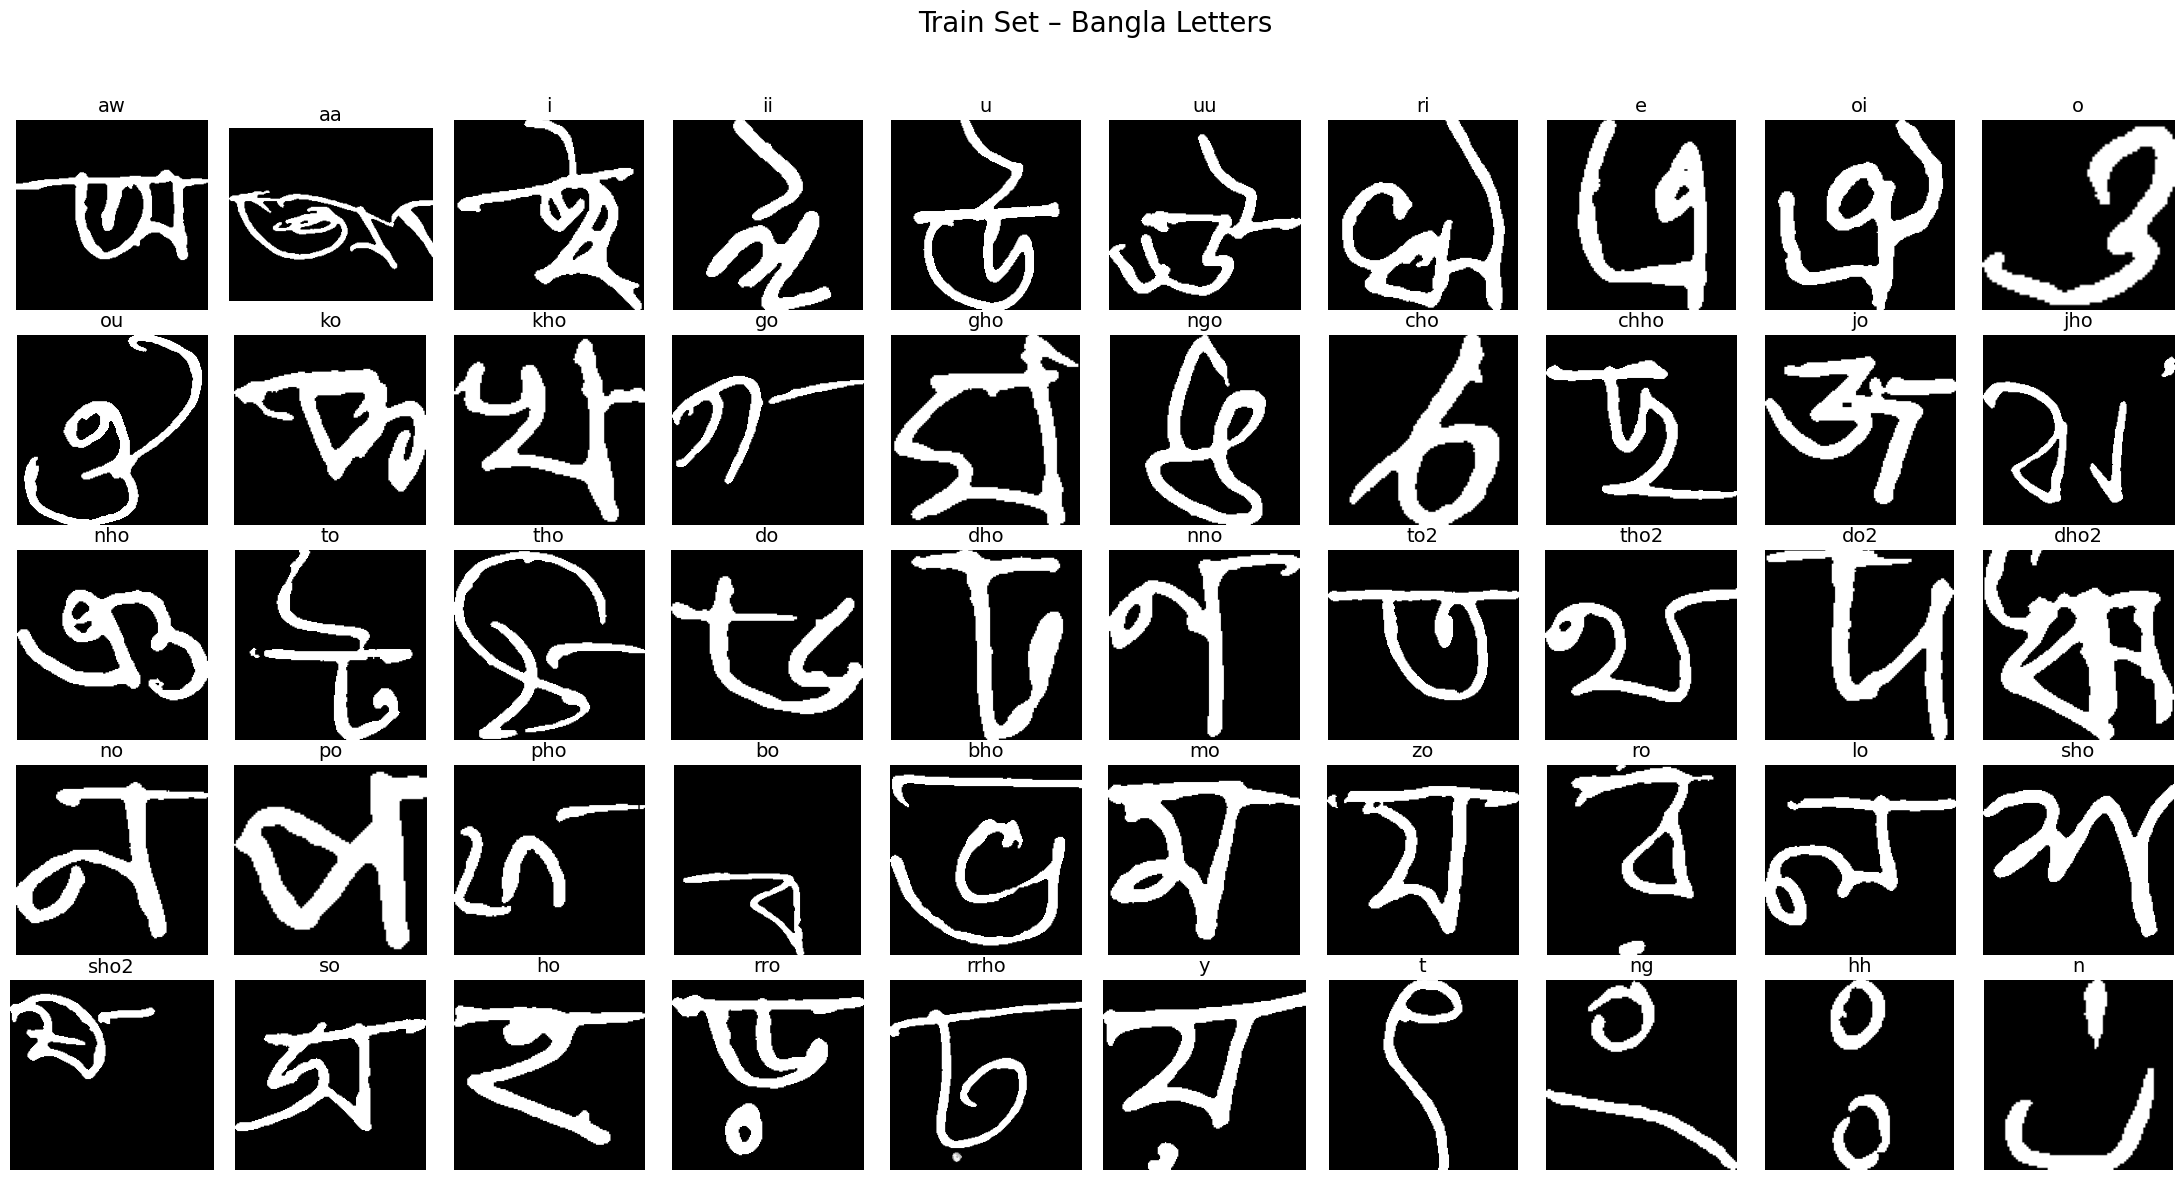

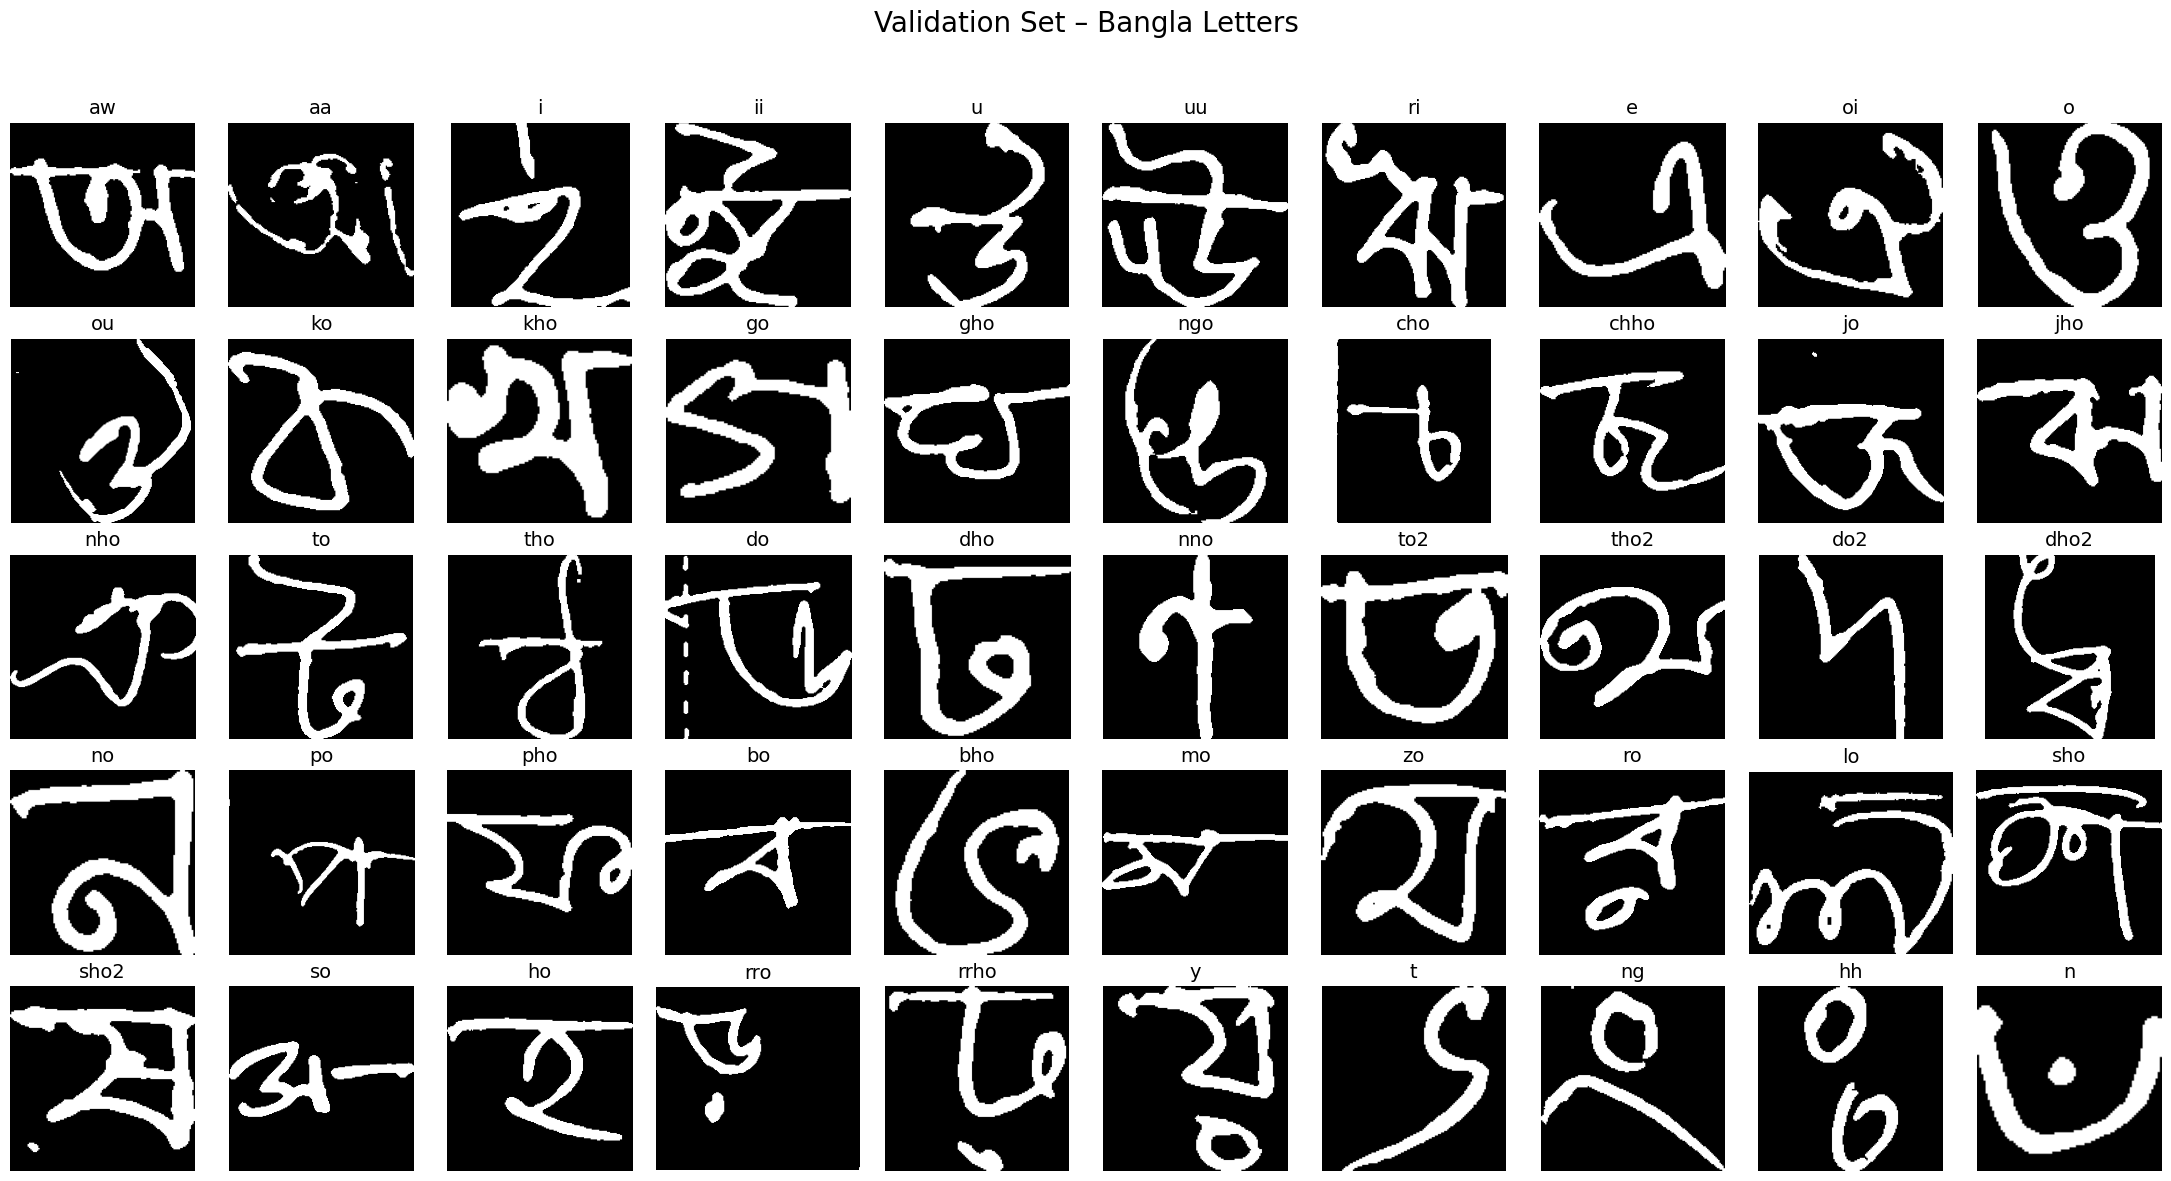

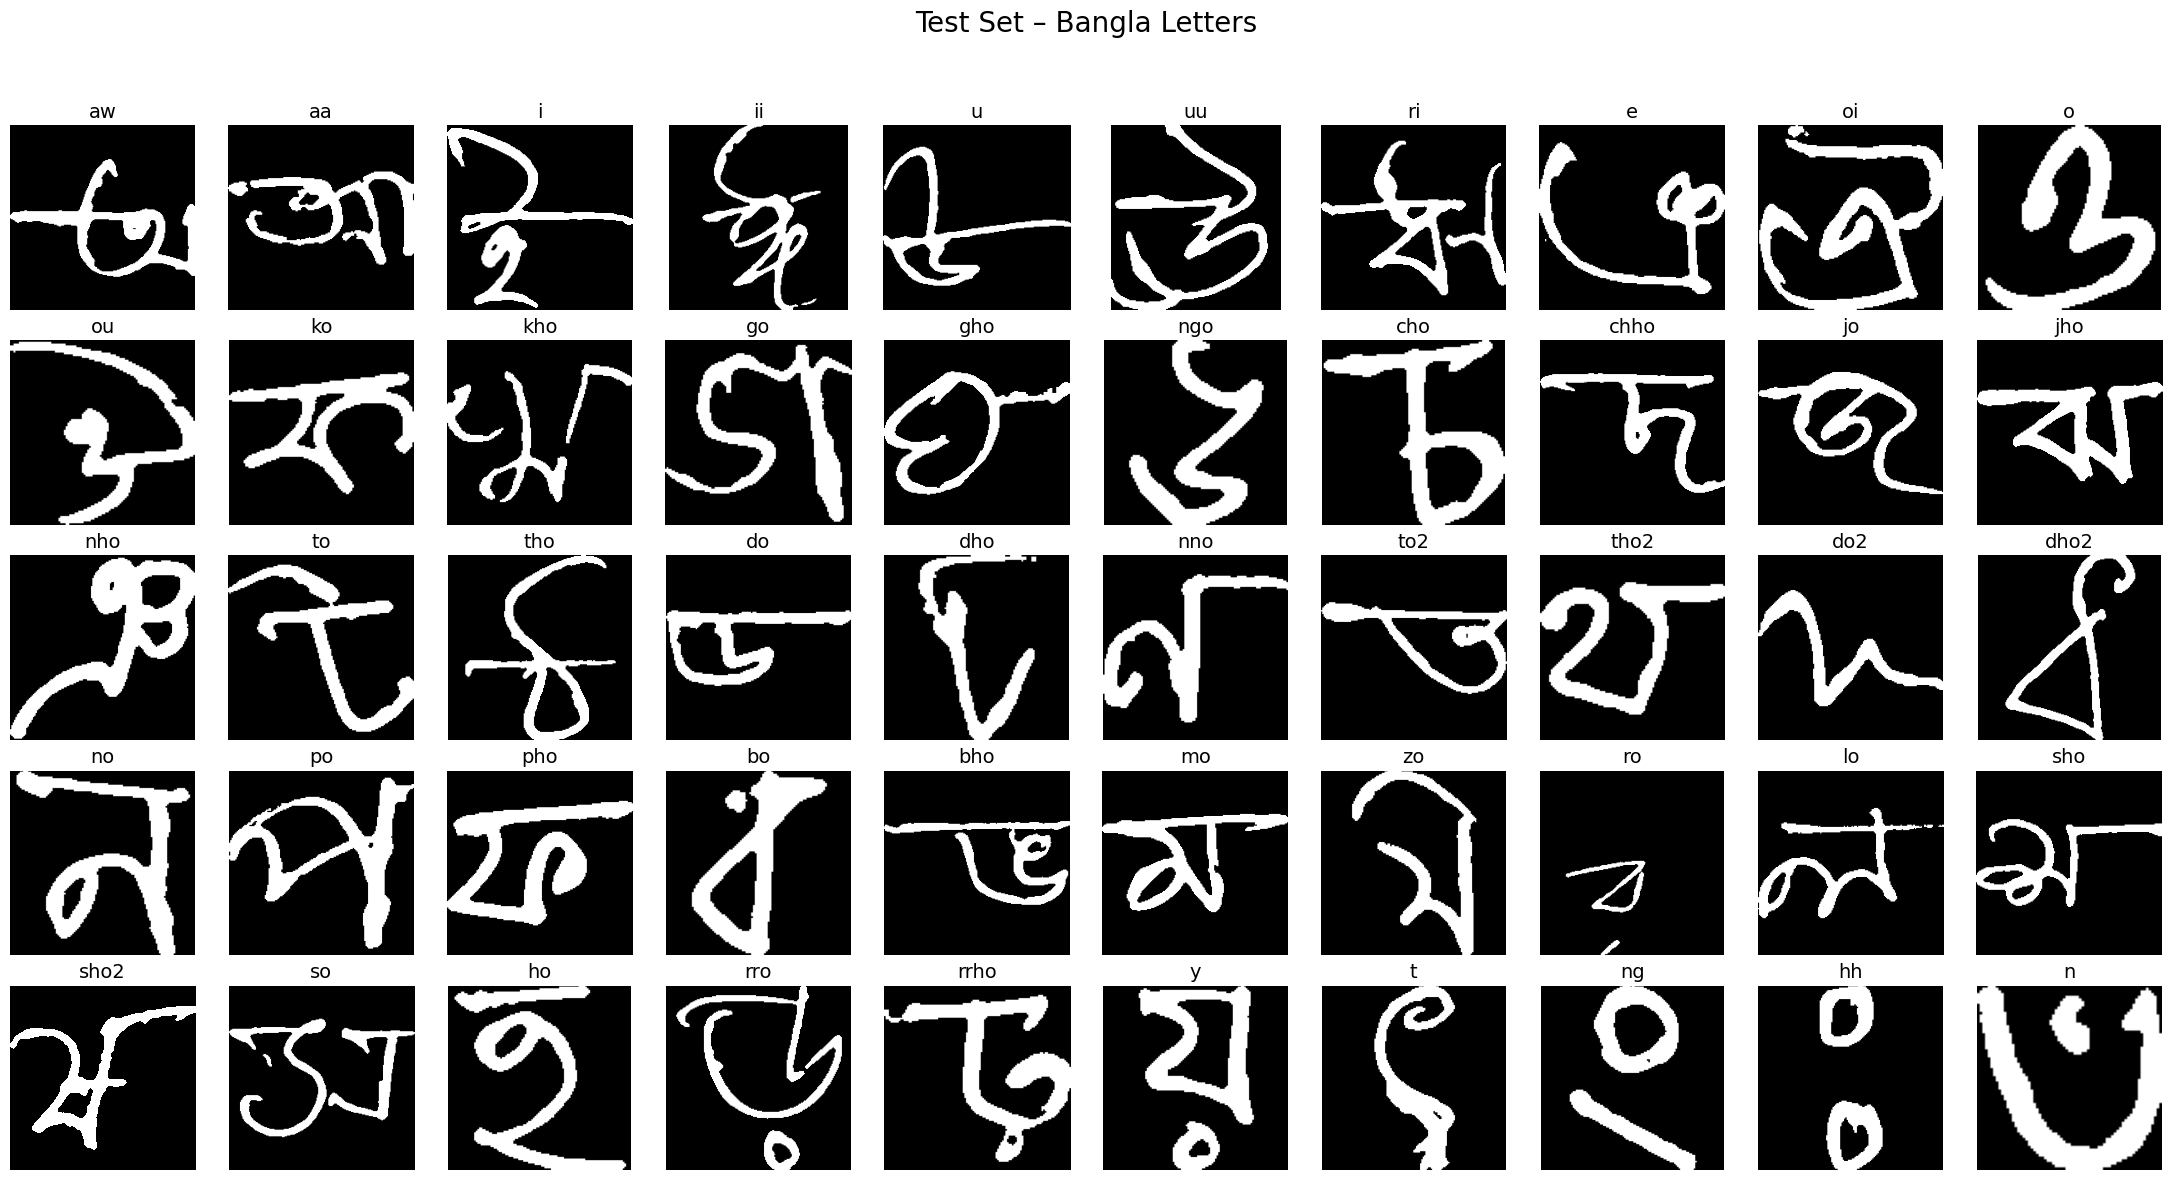

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_bangla_letters_english_label(folder, title="Bangla Letters – Sample Images", num_classes=50):
    plt.figure(figsize=(22, 12))
    shown = 0

    # Sort folders numerically by prefix, e.g. "00_aw_অ"
    class_folders = sorted(os.listdir(folder), key=lambda x: int(x.split('_')[0]))

    for idx, class_name in enumerate(class_folders[:num_classes]):
        class_path = os.path.join(folder, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg'))]
        if not image_files:
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = mpimg.imread(img_path)

        # Parse folder name: "00_aw_অ"
        parts = class_name.split('_')
        eng_label = parts[1]

        plt.subplot(5, 10, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{eng_label}", fontsize=14)
        plt.axis('off')
        shown += 1

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Paths for your splits
output_base = "/kaggle/working/banglalekha_letters_split"

# Visualize train, validation, test sets
visualize_bangla_letters_english_label(os.path.join(output_base, 'train'), "Train Set – Bangla Letters")
visualize_bangla_letters_english_label(os.path.join(output_base, 'val'), "Validation Set – Bangla Letters")
visualize_bangla_letters_english_label(os.path.join(output_base, 'test'), "Test Set – Bangla Letters")


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 60
num_classes = 50  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/banglalekha_letters_split/train"
val_path   = "/kaggle/working/banglalekha_letters_split/val"
test_path  = "/kaggle/working/banglalekha_letters_split/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


2025-06-12 00:40:05.661555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749688805.835324      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749688805.885120      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 69244 images belonging to 50 classes.
Found 14839 images belonging to 50 classes.
Found 14867 images belonging to 50 classes.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=50):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Slightly increased dropout

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(1024)(x)  # Increased size
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhanced')
    return model

print("Model is initialized!")

Model is initialized!


In [6]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749688894.442023      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749688894.442768      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNetEnhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,398,514 (20.59 MB)

 Trainable params: 5,394,674 (20.58 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [7]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_Bangla10Classes_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=60

In [8]:
# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749688958.339054     132 service.cc:148] XLA service 0x7fecb0021240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749688958.340019     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749688958.340037     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749688959.057114     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1082 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.0157 - loss: 4.7506     

I0000 00:00:1749688966.586299     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1081/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5416 - loss: 1.7374
Epoch 1: val_accuracy improved from -inf to 0.88685, saving model to scriptnet_Bangla10Classes_best.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step - accuracy: 0.5419 - loss: 1.7361 - val_accuracy: 0.8869 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 2/60
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8580 - loss: 0.4891
Epoch 2: val_accuracy improved from 0.88685 to 0.89029, saving model to scriptnet_Bangla10Classes_best.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 51s 47ms/step - accuracy: 0.8580 - loss: 0.4891 - val_accuracy: 0.8903 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 3/60
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8876 - loss: 0.3888
Epoch 3: val_accuracy improved from 0.89029 to 0.91853, saving model to scriptnet_Bangla10Classes_best.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 51s 47ms/step - accuracy: 0.8876 - loss: 0.3888 - val_accuracy: 0.9185 - val_loss: 0.2883 - learning_rate: 0

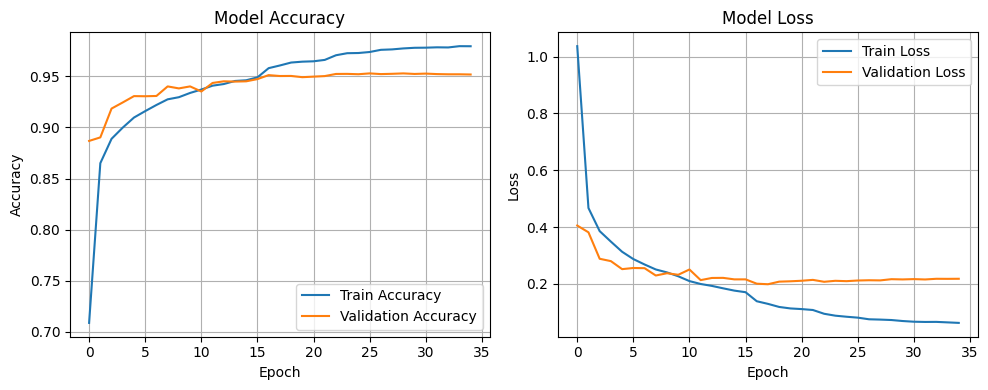

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


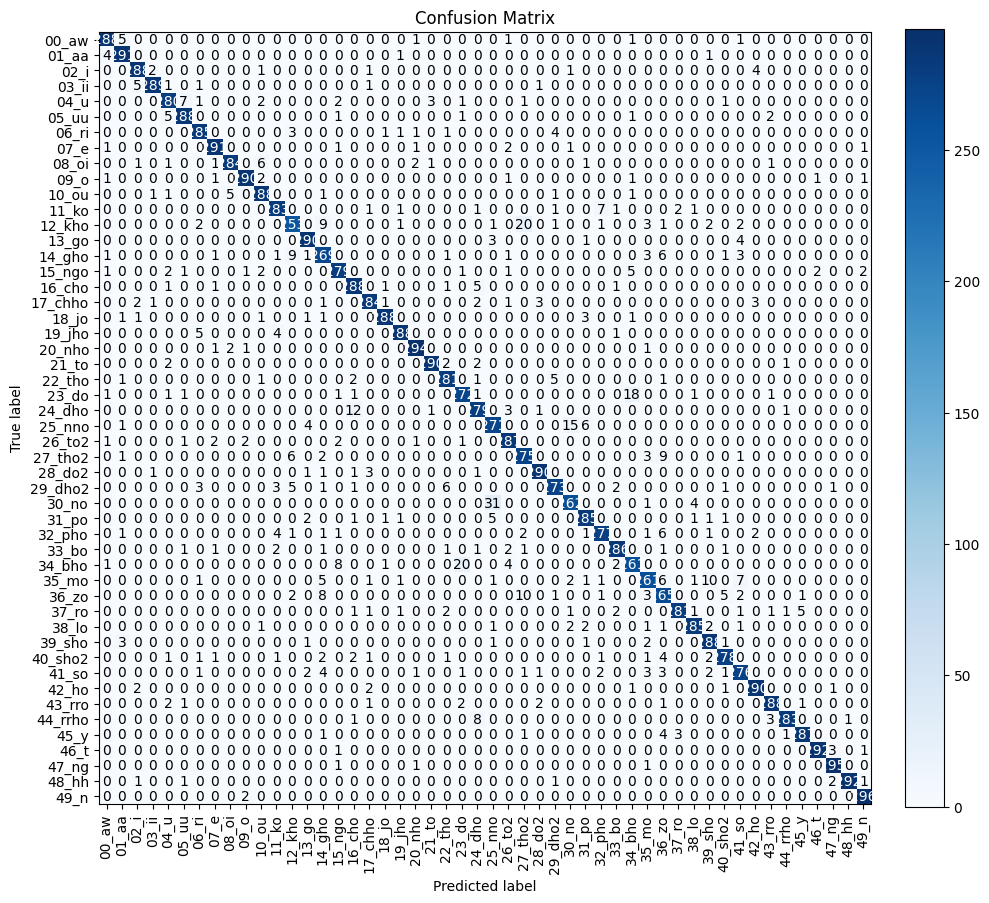

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create the plot manually to control the layout
fig, ax = plt.subplots(figsize=(10, 10))  # Size based on number of classes
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # ⬅ Match matrix height

# Add labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label',
    title="Confusion Matrix"
)

# Rotate the tick labels and set font sizes
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

# Annotate each cell with its count
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
📋 Classification Report:

              precision    recall  f1-score   support

       00_aw     0.9632    0.9697    0.9664       297
       01_aa     0.9572    0.9798    0.9684       297
        02_i     0.9600    0.9697    0.9648       297
       03_ii     0.9830    0.9698    0.9764       298
        04_u     0.9428    0.9396    0.9412       298
       05_uu     0.9568    0.9664    0.9616       298
       06_ri     0.9500    0.9628    0.9564       296
        07_e     0.9700    0.9765    0.9732       298
       08_oi     0.9759    0.9530    0.9643       298
        09_o     0.9797    0.9732    0.9764       298
       10_ou     0.9474    0.9664    0.9568       298
       11_ko     0.9497    0.9497    0.9497       298
      12_kho     0.9068    0.8547    0.8800       296
       13_go     0.9603    0.9732    0.9667       298
      14_gho     0.8762    0.9057    0.8907       297
      15_ngo     0.9394    0.9394    0.9394       297
      16_cho 

In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Bangla labels (make sure they match class_indices order)
bangla_labels = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও',
    'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ',
    'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ',
    'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ',
    'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ'
]

# Print classification report
report = classification_report(y_true, y_pred, target_names=bangla_labels, digits=4)
print("📋 Bangla Classification Report:\n")
print(report)

# Macro & weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
📋 Bangla Classification Report:

              precision    recall  f1-score   support

           অ     0.9632    0.9697    0.9664       297
           আ     0.9572    0.9798    0.9684       297
           ই     0.9600    0.9697    0.9648       297
           ঈ     0.9830    0.9698    0.9764       298
           উ     0.9428    0.9396    0.9412       298
           ঊ     0.9568    0.9664    0.9616       298
           ঋ     0.9500    0.9628    0.9564       296
           এ     0.9700    0.9765    0.9732       298
           ঐ     0.9759    0.9530    0.9643       298
           ও     0.9797    0.9732    0.9764       298
           ঔ     0.9474    0.9664    0.9568       298
           ক     0.9497    0.9497    0.9497       298
           খ     0.9068    0.8547    0.8800       296
           গ     0.9603    0.9732    0.9667       298
           ঘ     0.8762    0.9057    0.8907       297
           ঙ     0.9394    0.9394    0.9394       297
      

In [15]:
!wget -q https://github.com/google/fonts/raw/main/ofl/notosansbengali/NotoSansBengali-Regular.ttf -O NotoSansBengali-Regular.ttf


In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Load the downloaded font
bangla_font_path = "NotoSansBengali-Regular.ttf"
bangla_font = fm.FontProperties(fname=bangla_font_path)

# Later in the plotting code: use fontproperties=bangla_font


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


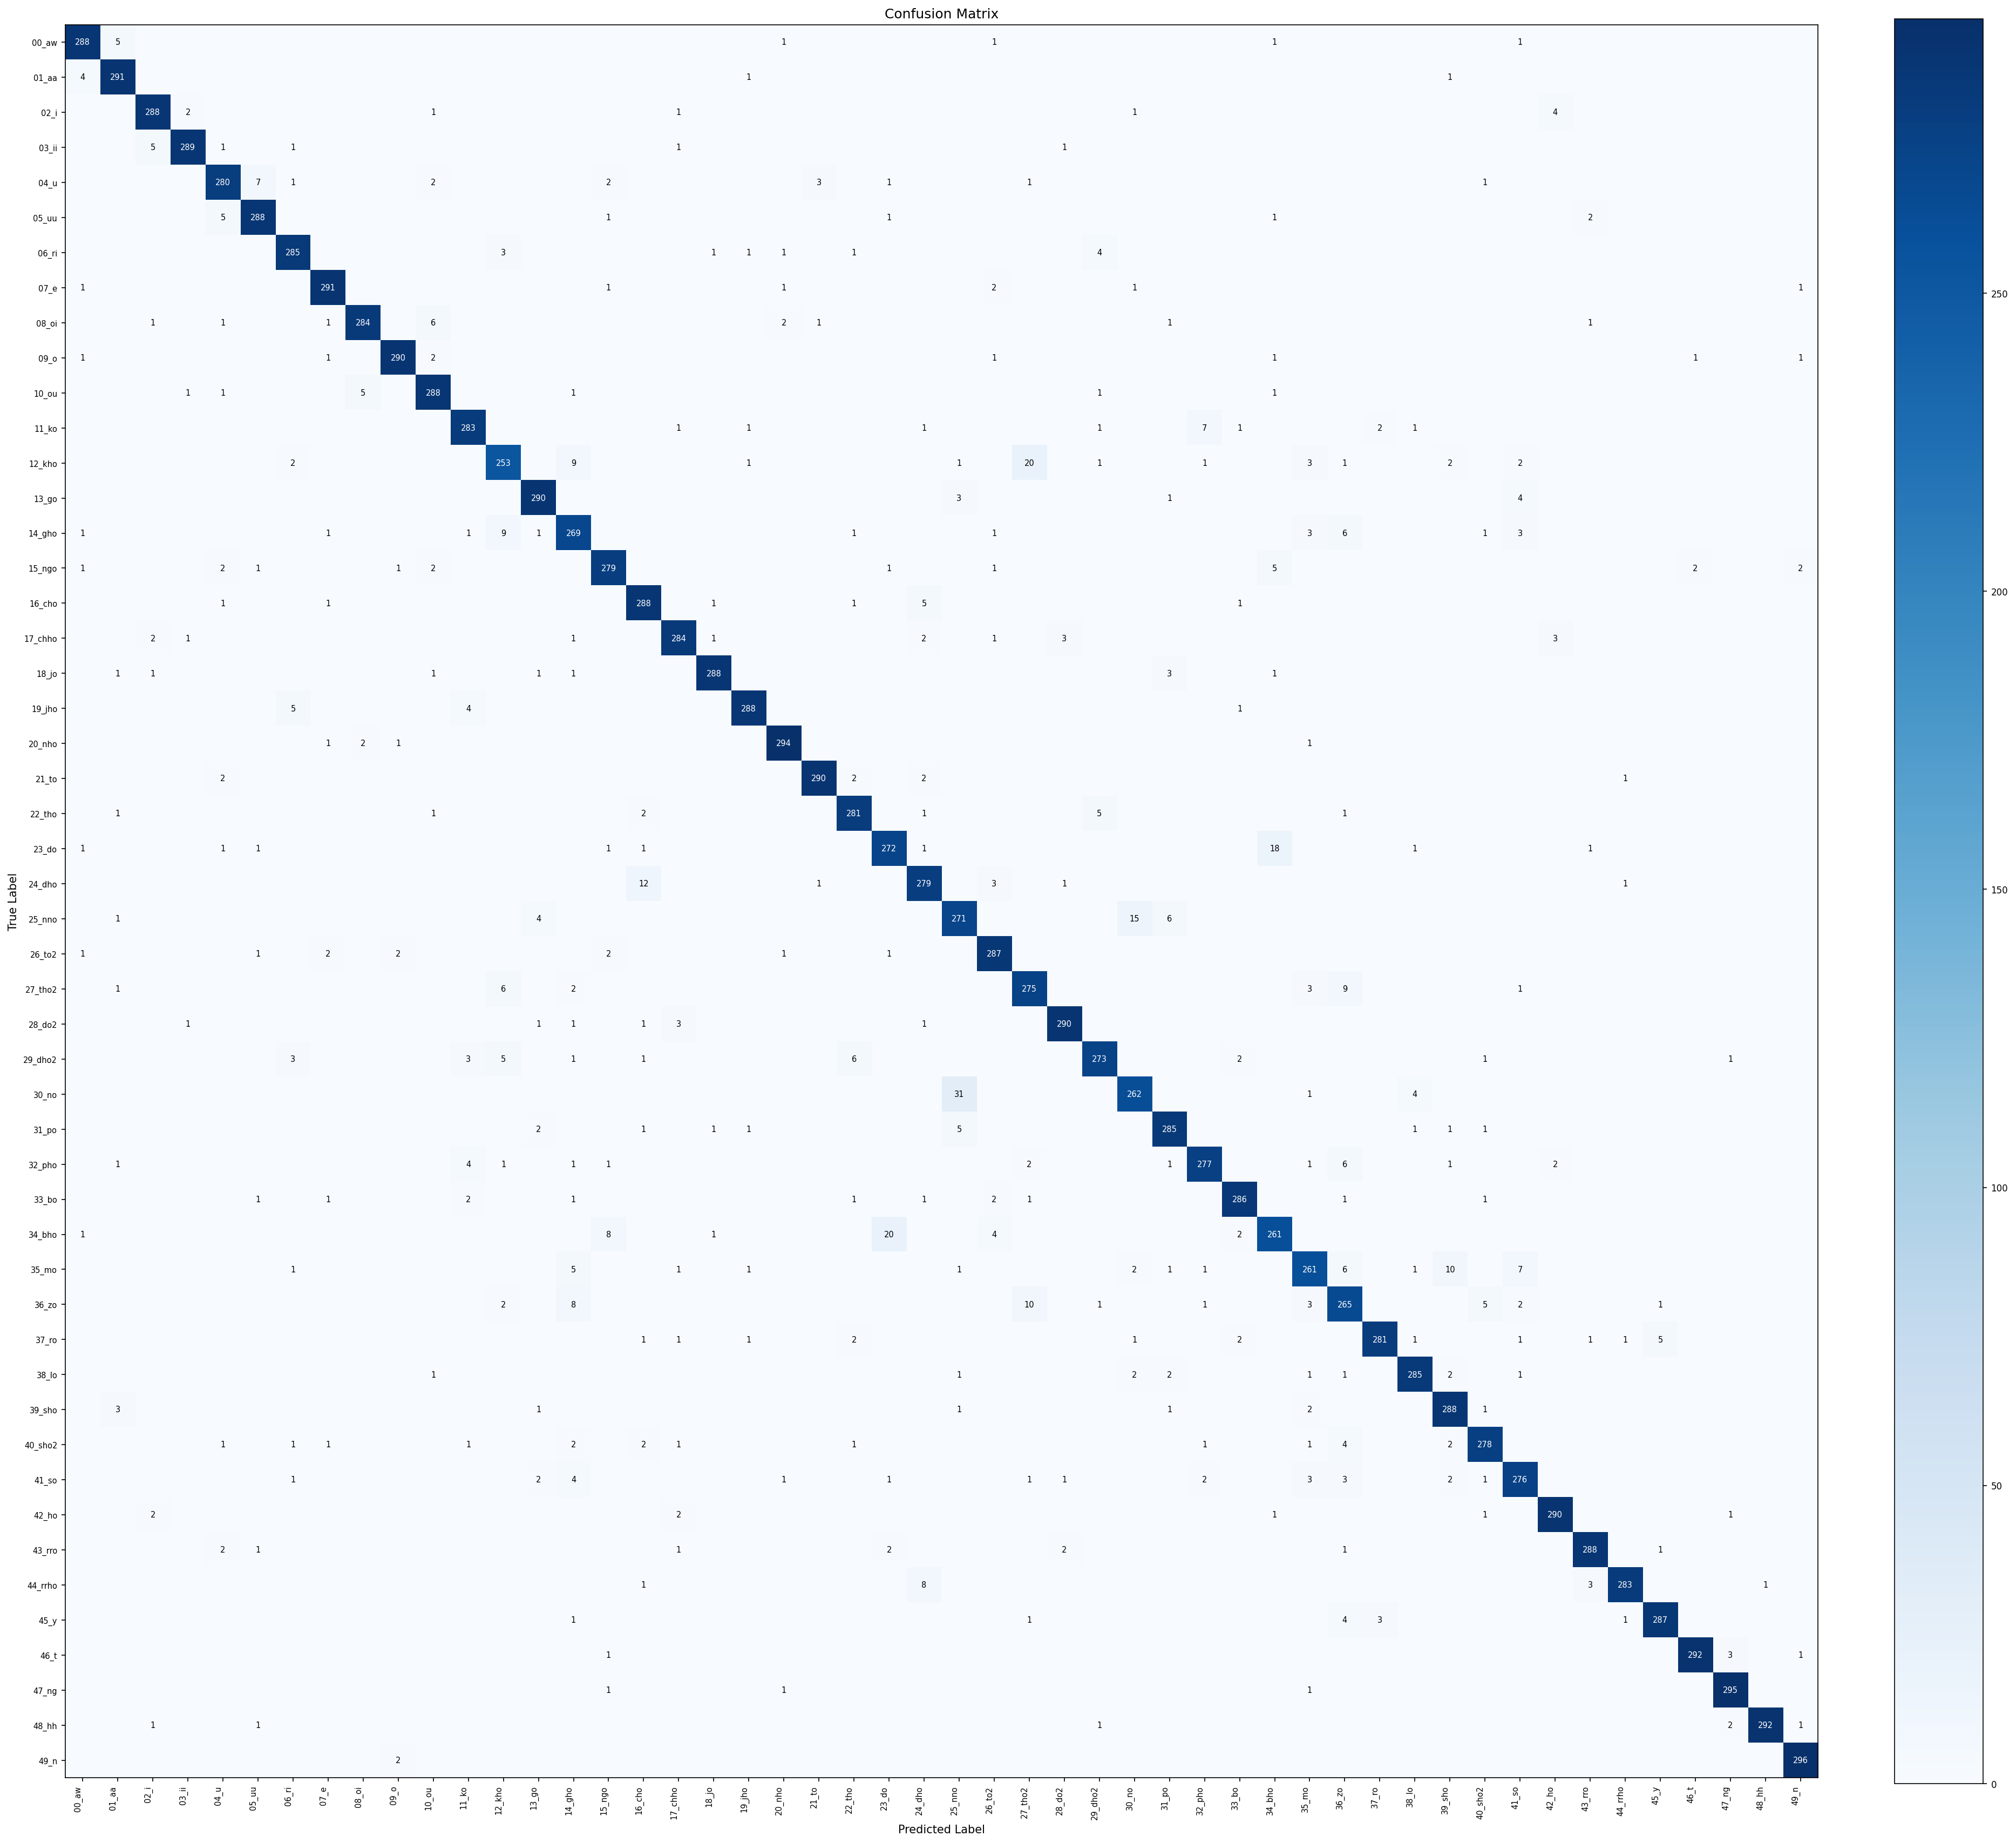

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size based on number of classes (scaled for ~50 classes)
    cell_scale = 0.5  # slightly bigger than your original 0.45 for clarity
    fig_width = min(30, max(10, num_classes * cell_scale))
    fig_height = min(30, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=150)  # dpi=150 for higher quality

    # Display matrix as image with a blue colormap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar height matches matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Adjust tick labels: smaller font size, rotate x labels for better fit
    tick_font = max(5, 12 - num_classes // 10)
    rotation_angle = 90 if num_classes > 20 else 45
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Annotate cells with counts, smaller font for large matrix
    fmt = 'd'
    thresh = cm.max() / 2.
    annotation_font = max(5, 12 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:  # annotate only non-zero counts to reduce clutter
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage (in your notebook):
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


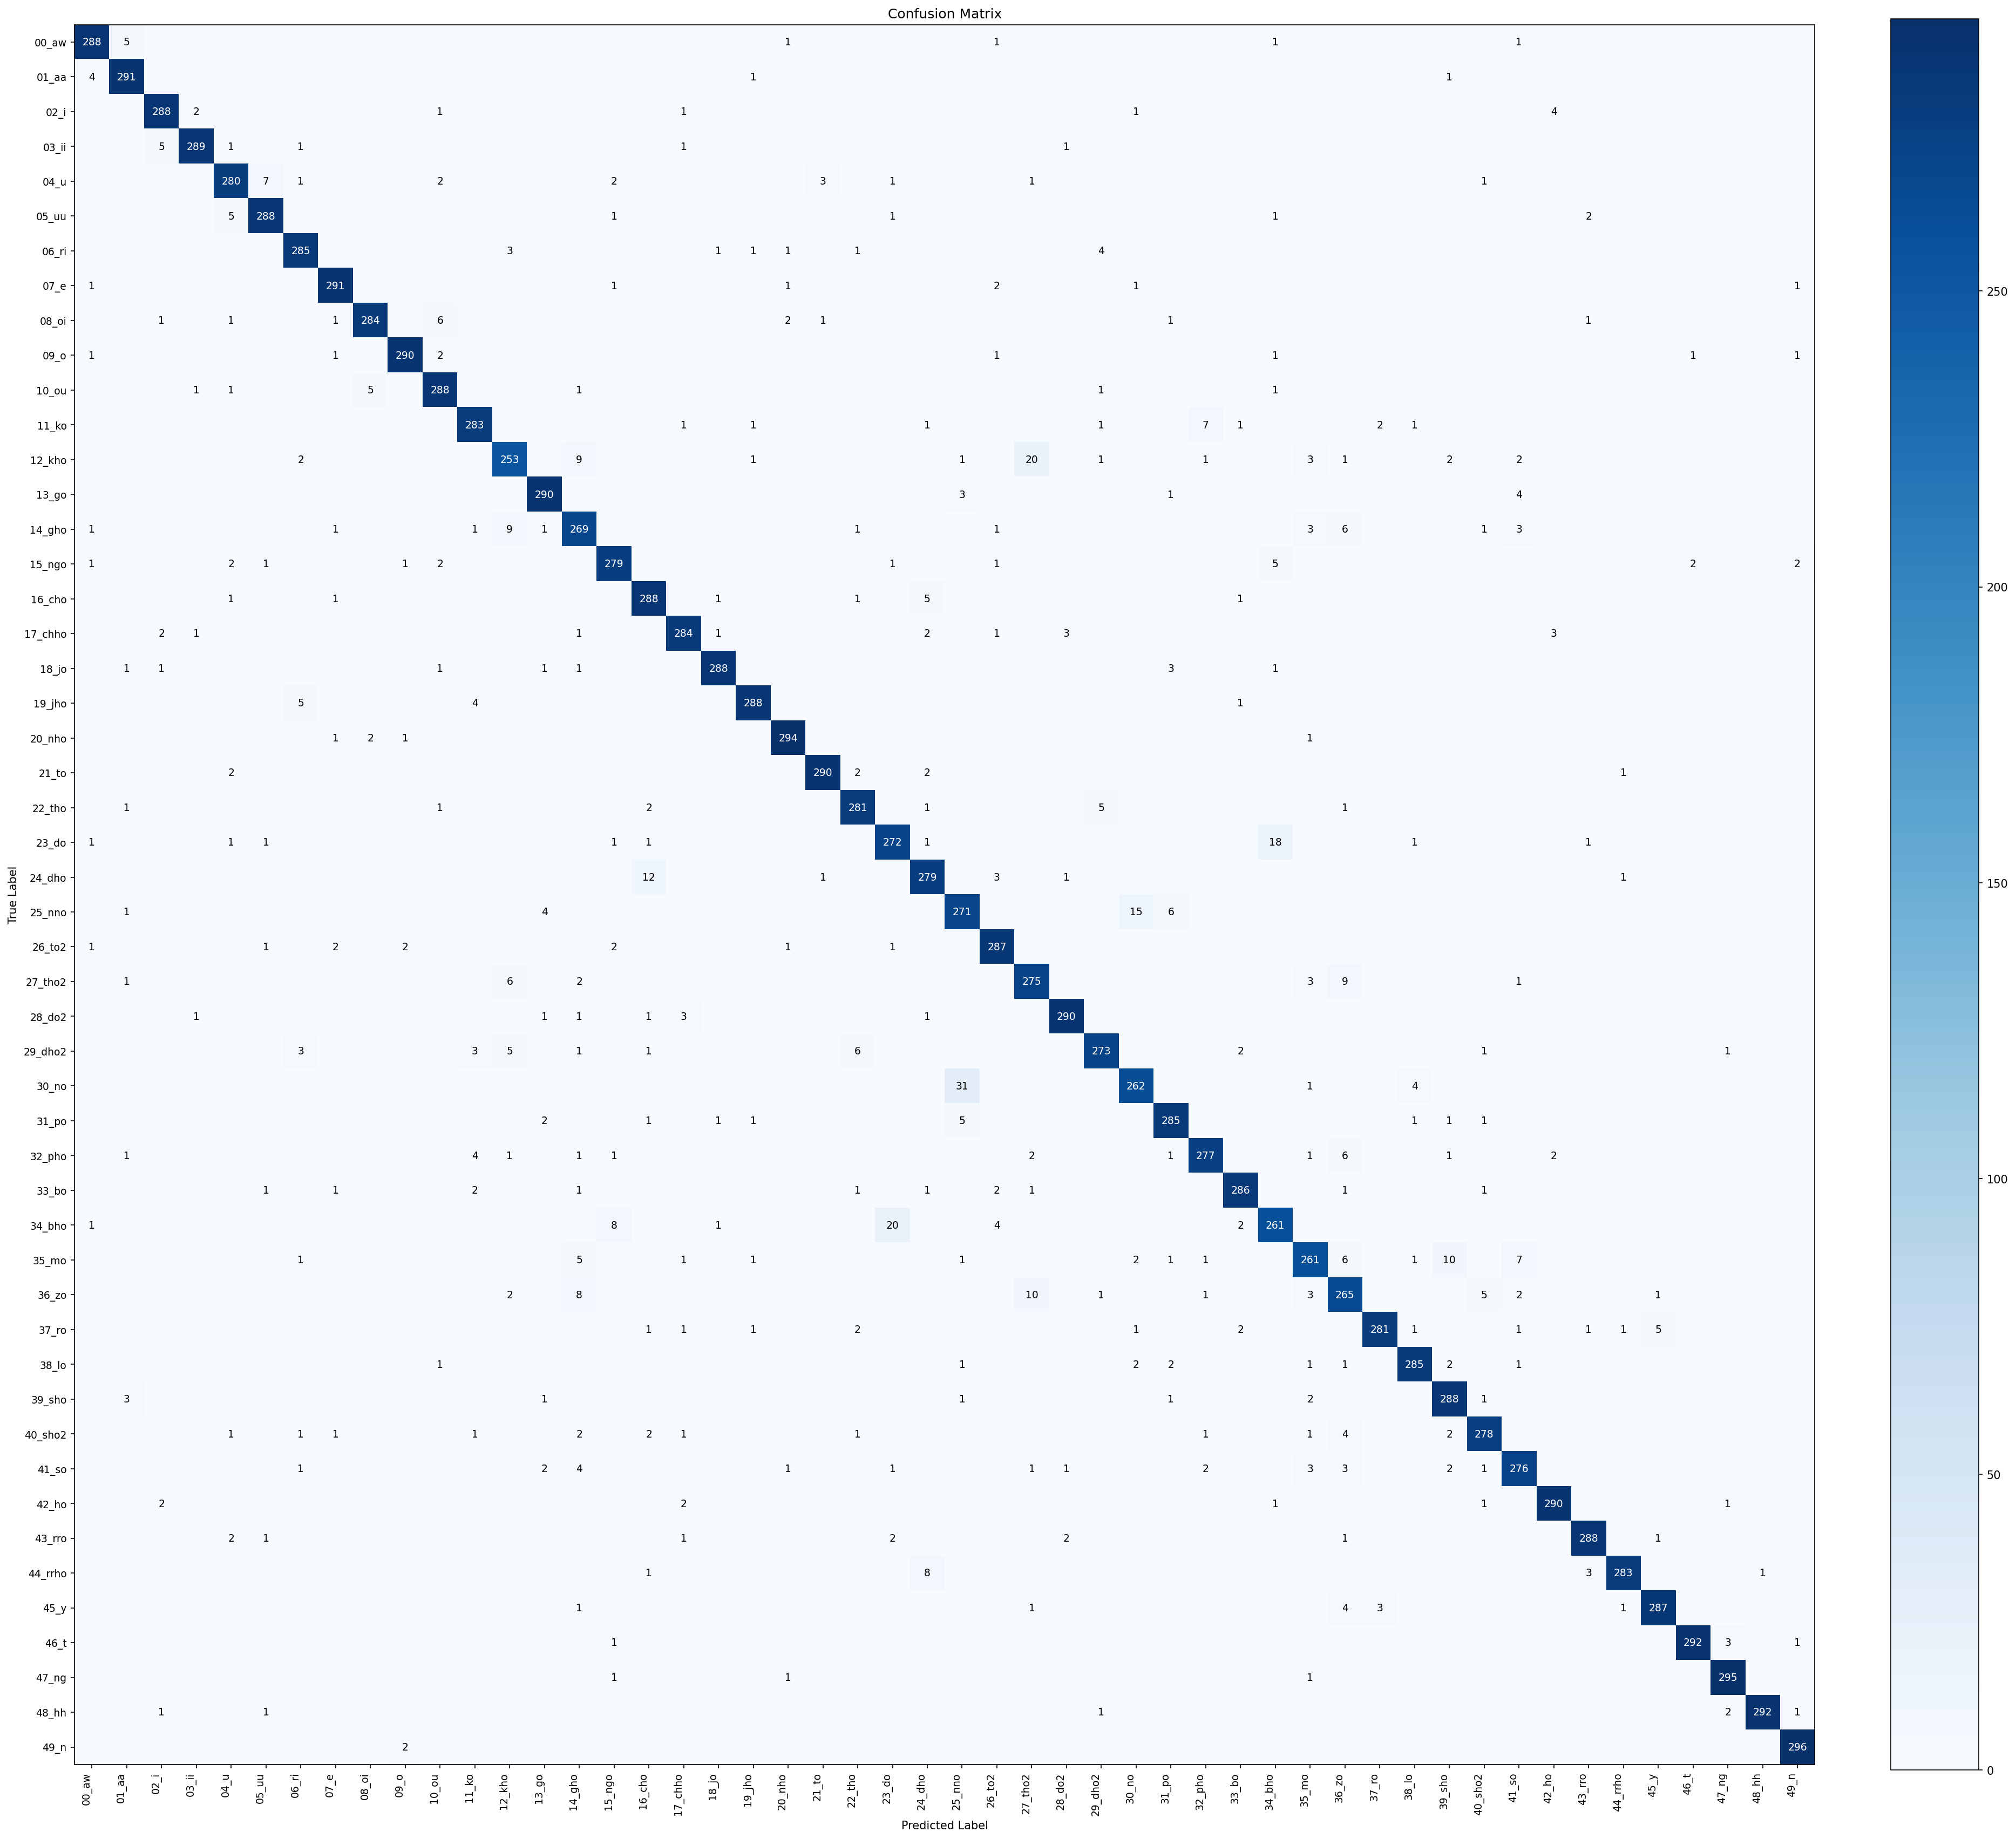

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size based on number of classes (scaled for ~50 classes)
    cell_scale = 0.5
    fig_width = min(30, max(10, num_classes * cell_scale))
    fig_height = min(30, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=150)

    # Display matrix as image with a blue colormap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar height matches matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)  # larger colorbar font

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Adjust tick labels: bigger font size, rotated x labels for better fit
    tick_font = max(8, 14 - num_classes // 10)  # increased base font size
    rotation_angle = 90 if num_classes > 20 else 45
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Annotate cells with counts, bigger font for large matrix
    fmt = 'd'
    thresh = cm.max() / 2.
    annotation_font = max(7, 14 - num_classes // 10)  # increased annotation font size
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


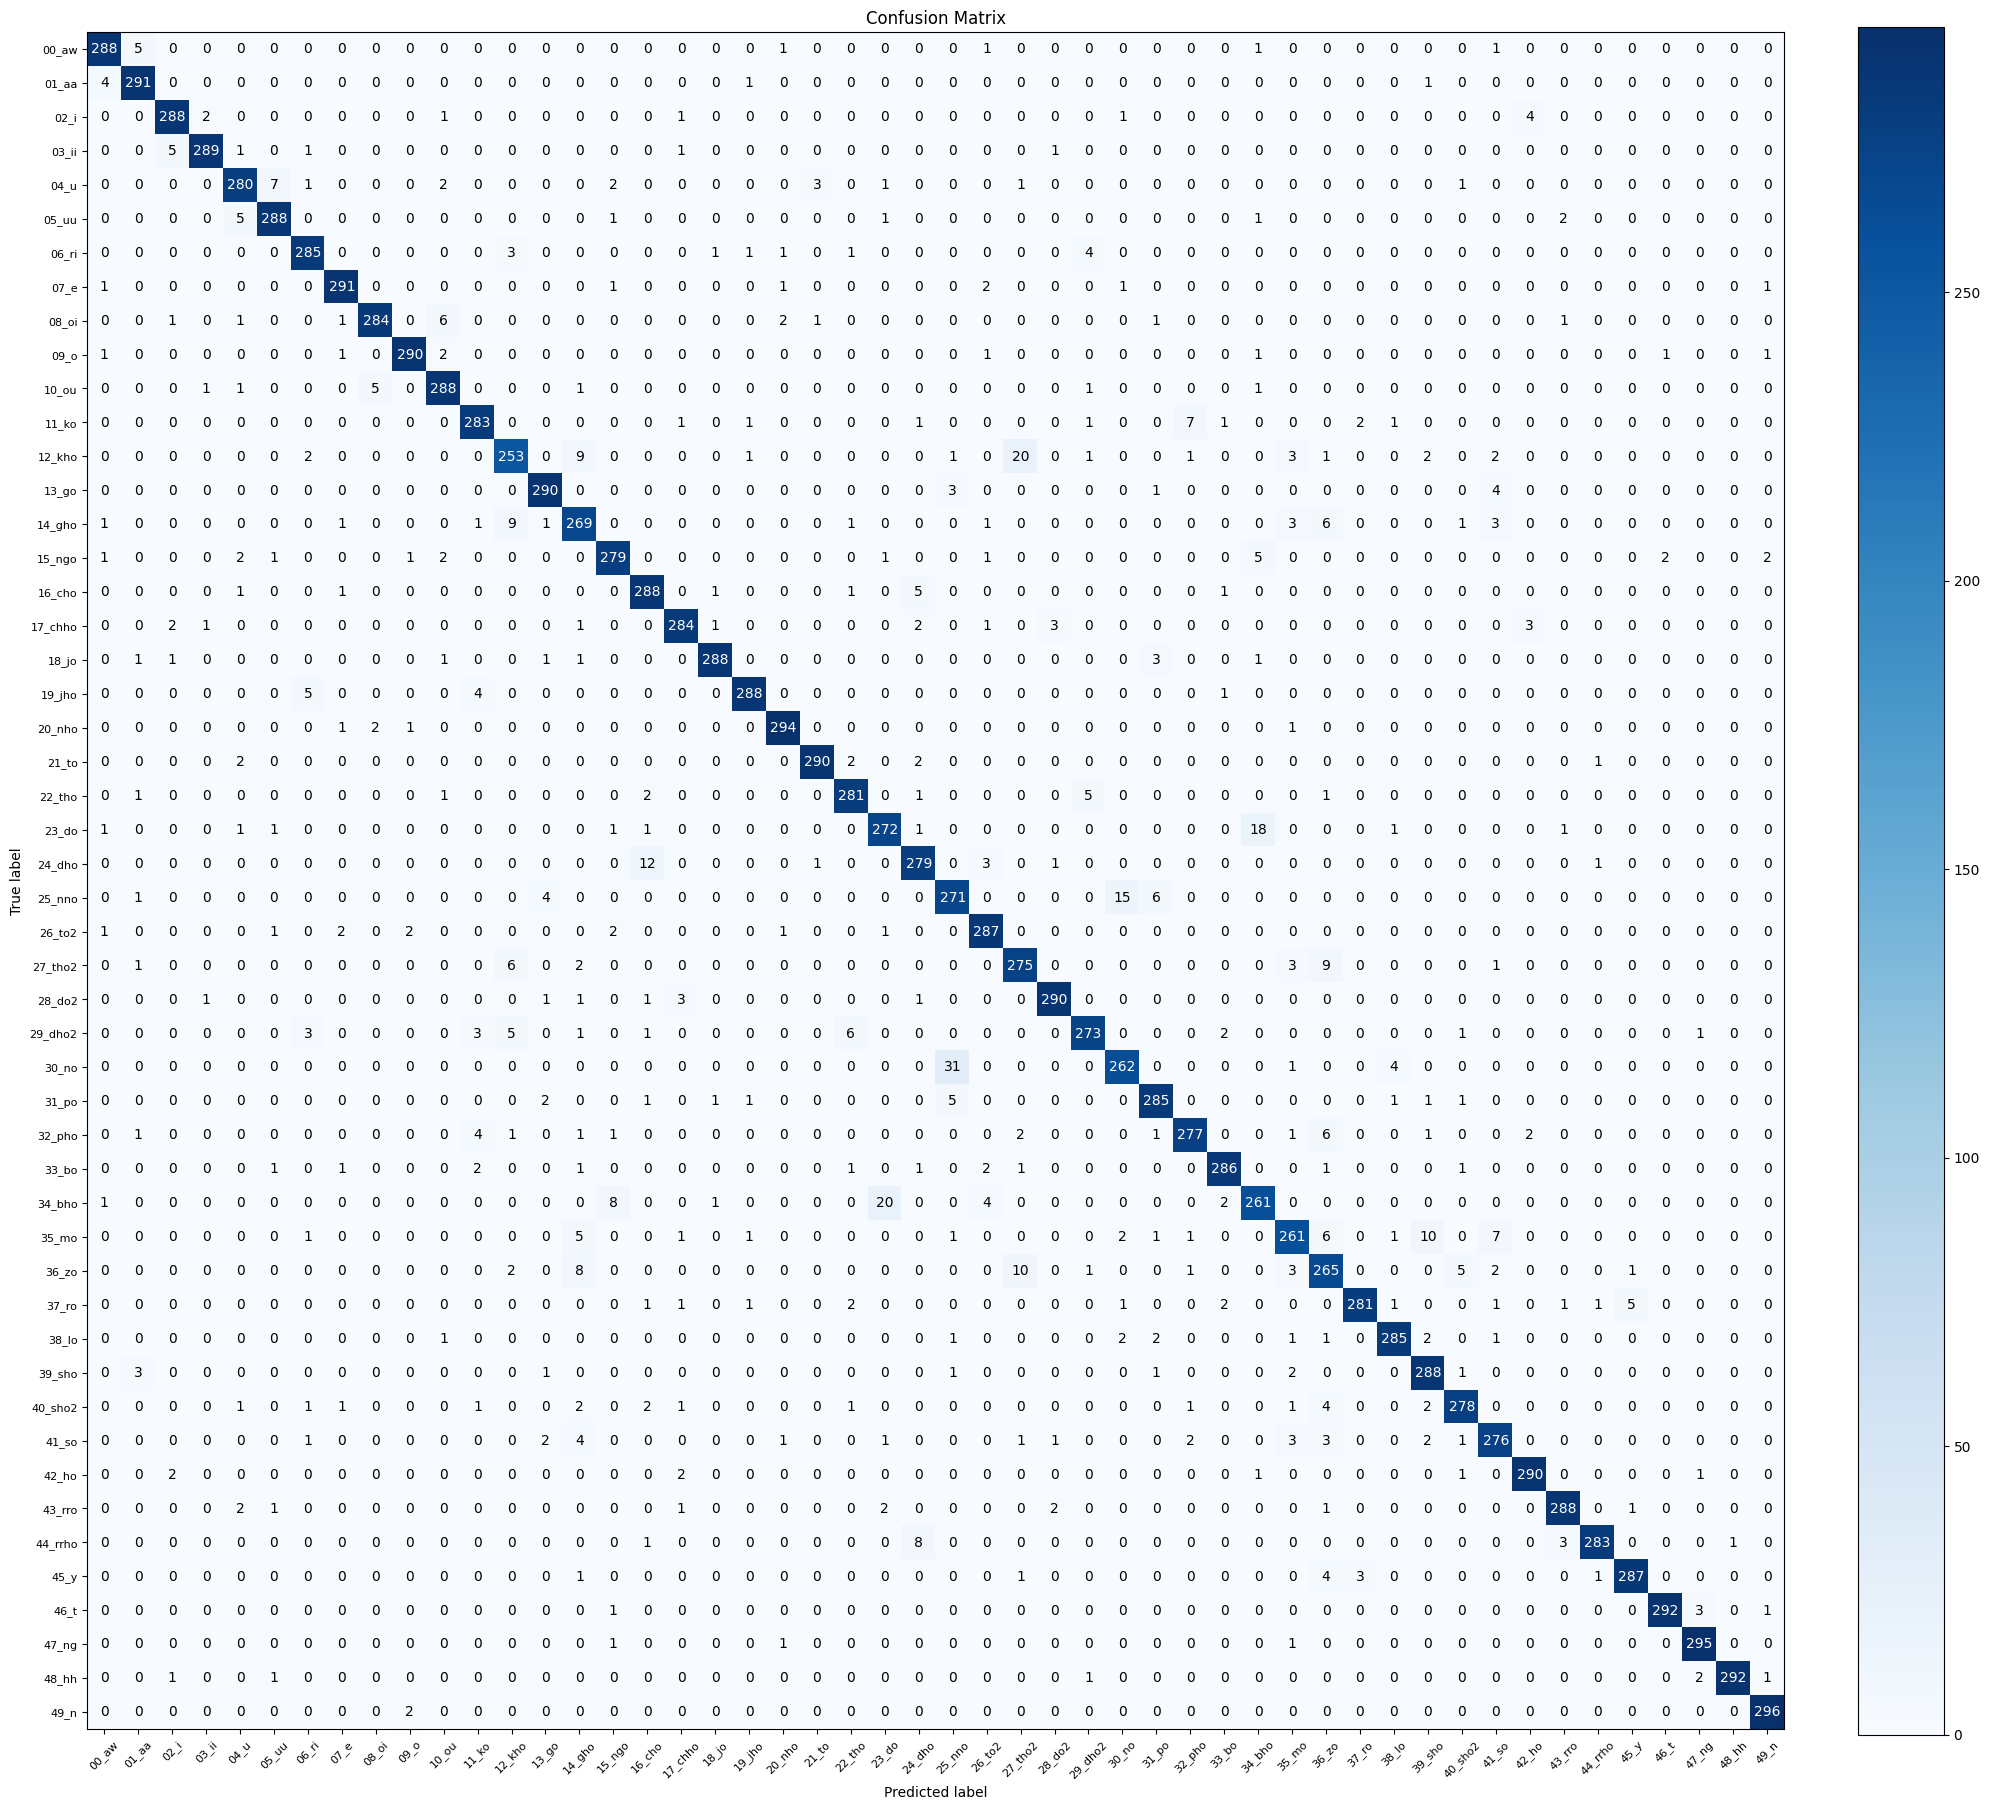

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create the plot manually to control the layout
fig, ax = plt.subplots(figsize=(20, 20))  # Size based on number of classes
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # ⬅ Match matrix height

# Add labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label',
    title="Confusion Matrix"
)

# Rotate the tick labels and set font sizes
plt.setp(ax.get_xticklabels(), rotation=45, ha="center", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)

# Annotate each cell with its count
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(50)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |     297 |       0.9697 |             288.0000 |       0.9992 |             296.7758
    1 |     297 |       0.9798 |             291.0000 |       0.9991 |             296.7350
    2 |     297 |       0.9697 |             288.0000 |       0.9992 |             296.7554
    3 |     298 |       0.9698 |             289.0000 |       0.9997 |             297.8977
    4 |     298 |       0.9396 |             280.0000 |       0.9988 |             297.6523
    5 |     298 |       0.9664 |             288.0000 |       0.9991 |             297.7341
    6 |     296 |       0.9628 |             285.0000 |       0.9990 |             295.6953
    7 |     298 |       0.9765 |             291.0000 |       0.9994 |             297.8159
    8 |     298 |       0.9530 |       

233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step

📋 Classification Report:

              precision    recall  f1-score   support

       00_aw     0.9632    0.9697    0.9664       297
       01_aa     0.9572    0.9798    0.9684       297
        02_i     0.9600    0.9697    0.9648       297
       03_ii     0.9830    0.9698    0.9764       298
        04_u     0.9428    0.9396    0.9412       298
       05_uu     0.9568    0.9664    0.9616       298
       06_ri     0.9500    0.9628    0.9564       296
        07_e     0.9700    0.9765    0.9732       298
       08_oi     0.9759    0.9530    0.9643       298
        09_o     0.9797    0.9732    0.9764       298
       10_ou     0.9474    0.9664    0.9568       298
       11_ko     0.9497    0.9497    0.9497       298
      12_kho     0.9068    0.8547    0.8800       296
       13_go     0.9603    0.9732    0.9667       298
      14_gho     0.8762    0.9057    0.8907       297
      15_ngo     0.9394    0.9394    0.9394       297
      16_cho

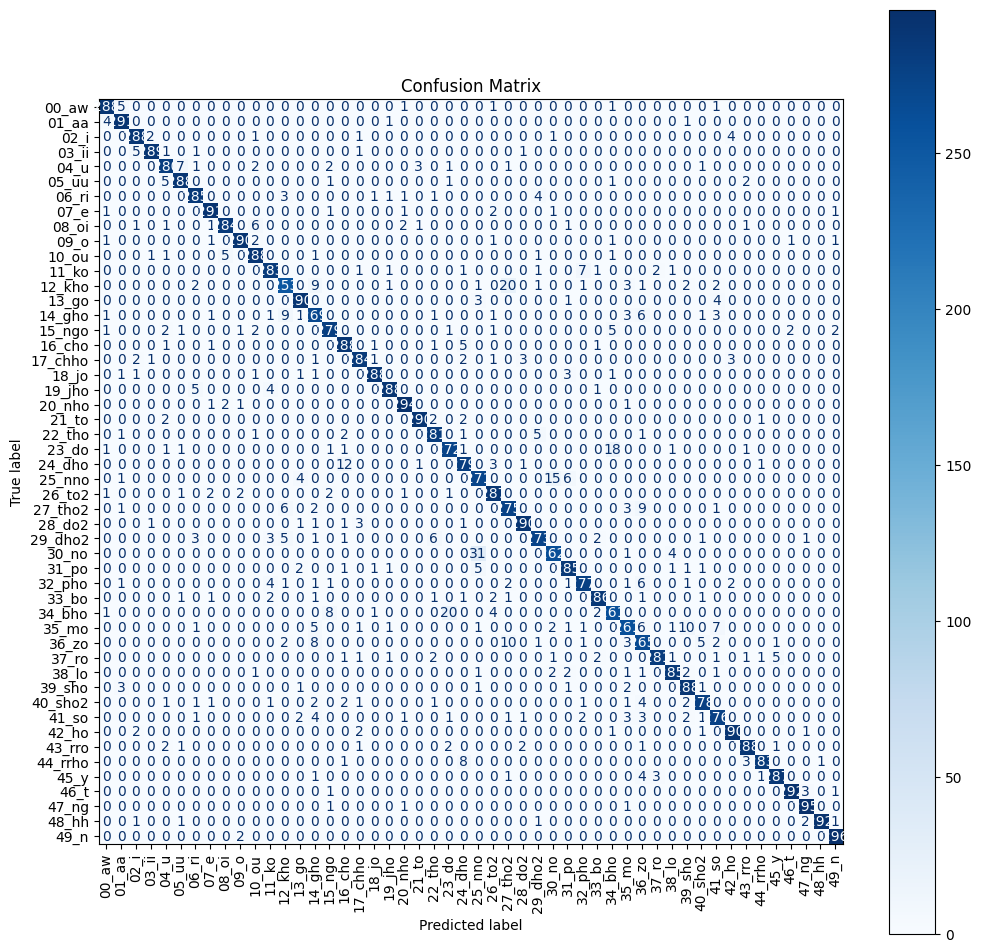


📈 ROC Curve (One-vs-Rest)


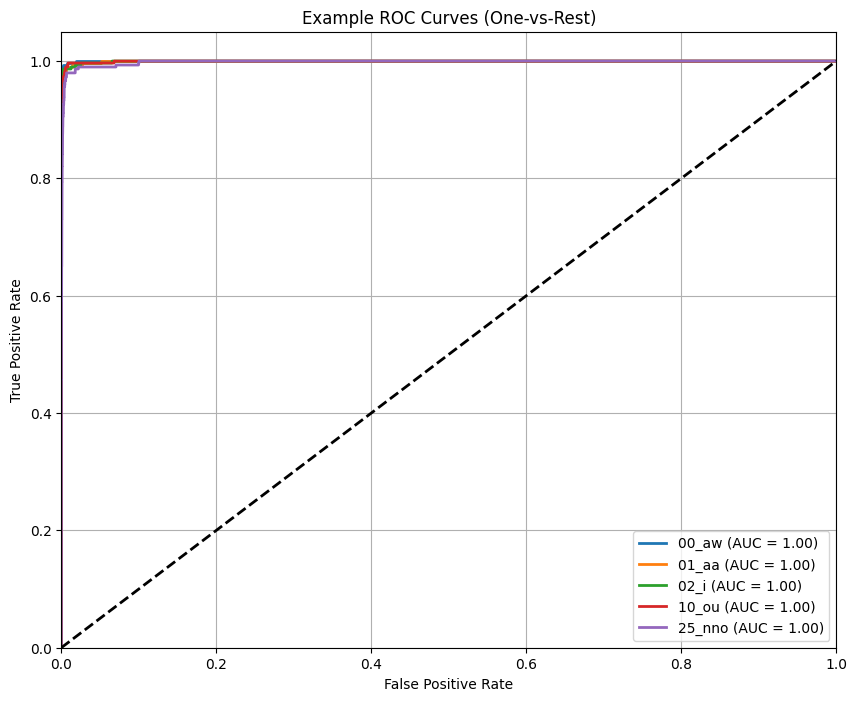

In [28]:
# Thesis Metrics and Visualization for EMNIST ByClass A-Z
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Classification Report
print("\n\U0001F4CB Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Macro & Weighted Scores
print("\n\U0001F522 Macro & Weighted Scores")
for average in ["macro", "weighted"]:
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"\n{average.capitalize()}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Per-Class Scores
print("\n\U0001F4DD Per-Class Metrics")
for i, label in enumerate(class_names):
    precision = precision_score(y_true == i, y_pred == i)
    recall = recall_score(y_true == i, y_pred == i)
    f1 = f1_score(y_true == i, y_pred == i)
    print(f"{label}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
print("\n\U0001F4C8 ROC Curve (One-vs-Rest)")
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot a few example ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 10))
for i, c in zip([0, 1, 2, 10, 25], colors):  # change to any class indices
    plt.plot(fpr[i], tpr[i], color=c, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Example ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
✅ Confusion matrix saved to: confusion_matrix.png


📋 Classification Report:

              precision    recall  f1-score   support

       00_aw     0.9632    0.9697    0.9664       297
       01_aa     0.9572    0.9798    0.9684       297
        02_i     0.9600    0.9697    0.9648       297
       03_ii     0.9830    0.9698    0.9764       298
        04_u     0.9428    0.9396    0.9412       298
       05_uu     0.9568    0.9664    0.9616       298
       06_ri     0.9500    0.9628    0.9564       296
        07_e     0.9700    0.9765    0.9732       298
       08_oi     0.9759    0.9530    0.9643       298
        09_o     0.9797    0.9732    0.9764       298
       10_ou     0.9474    0.9664    0.9568       298
       11_ko     0.9497    0.9497    0.9497       298
      12_kho     0.9068    0.8547    0.8800       296
       13_go     0.9603    0.9732    0.9667       298
      14_gho     0.8762    0.9057    0.8907       297
      15_ngo     0.9394    0.9394    0.9394       297
      16_cho     0.9290    0.9664    0.9474       298
 

/tmp/ipykernel_35/262129706.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


✅ ROC curve plot saved to: roc_curves.png


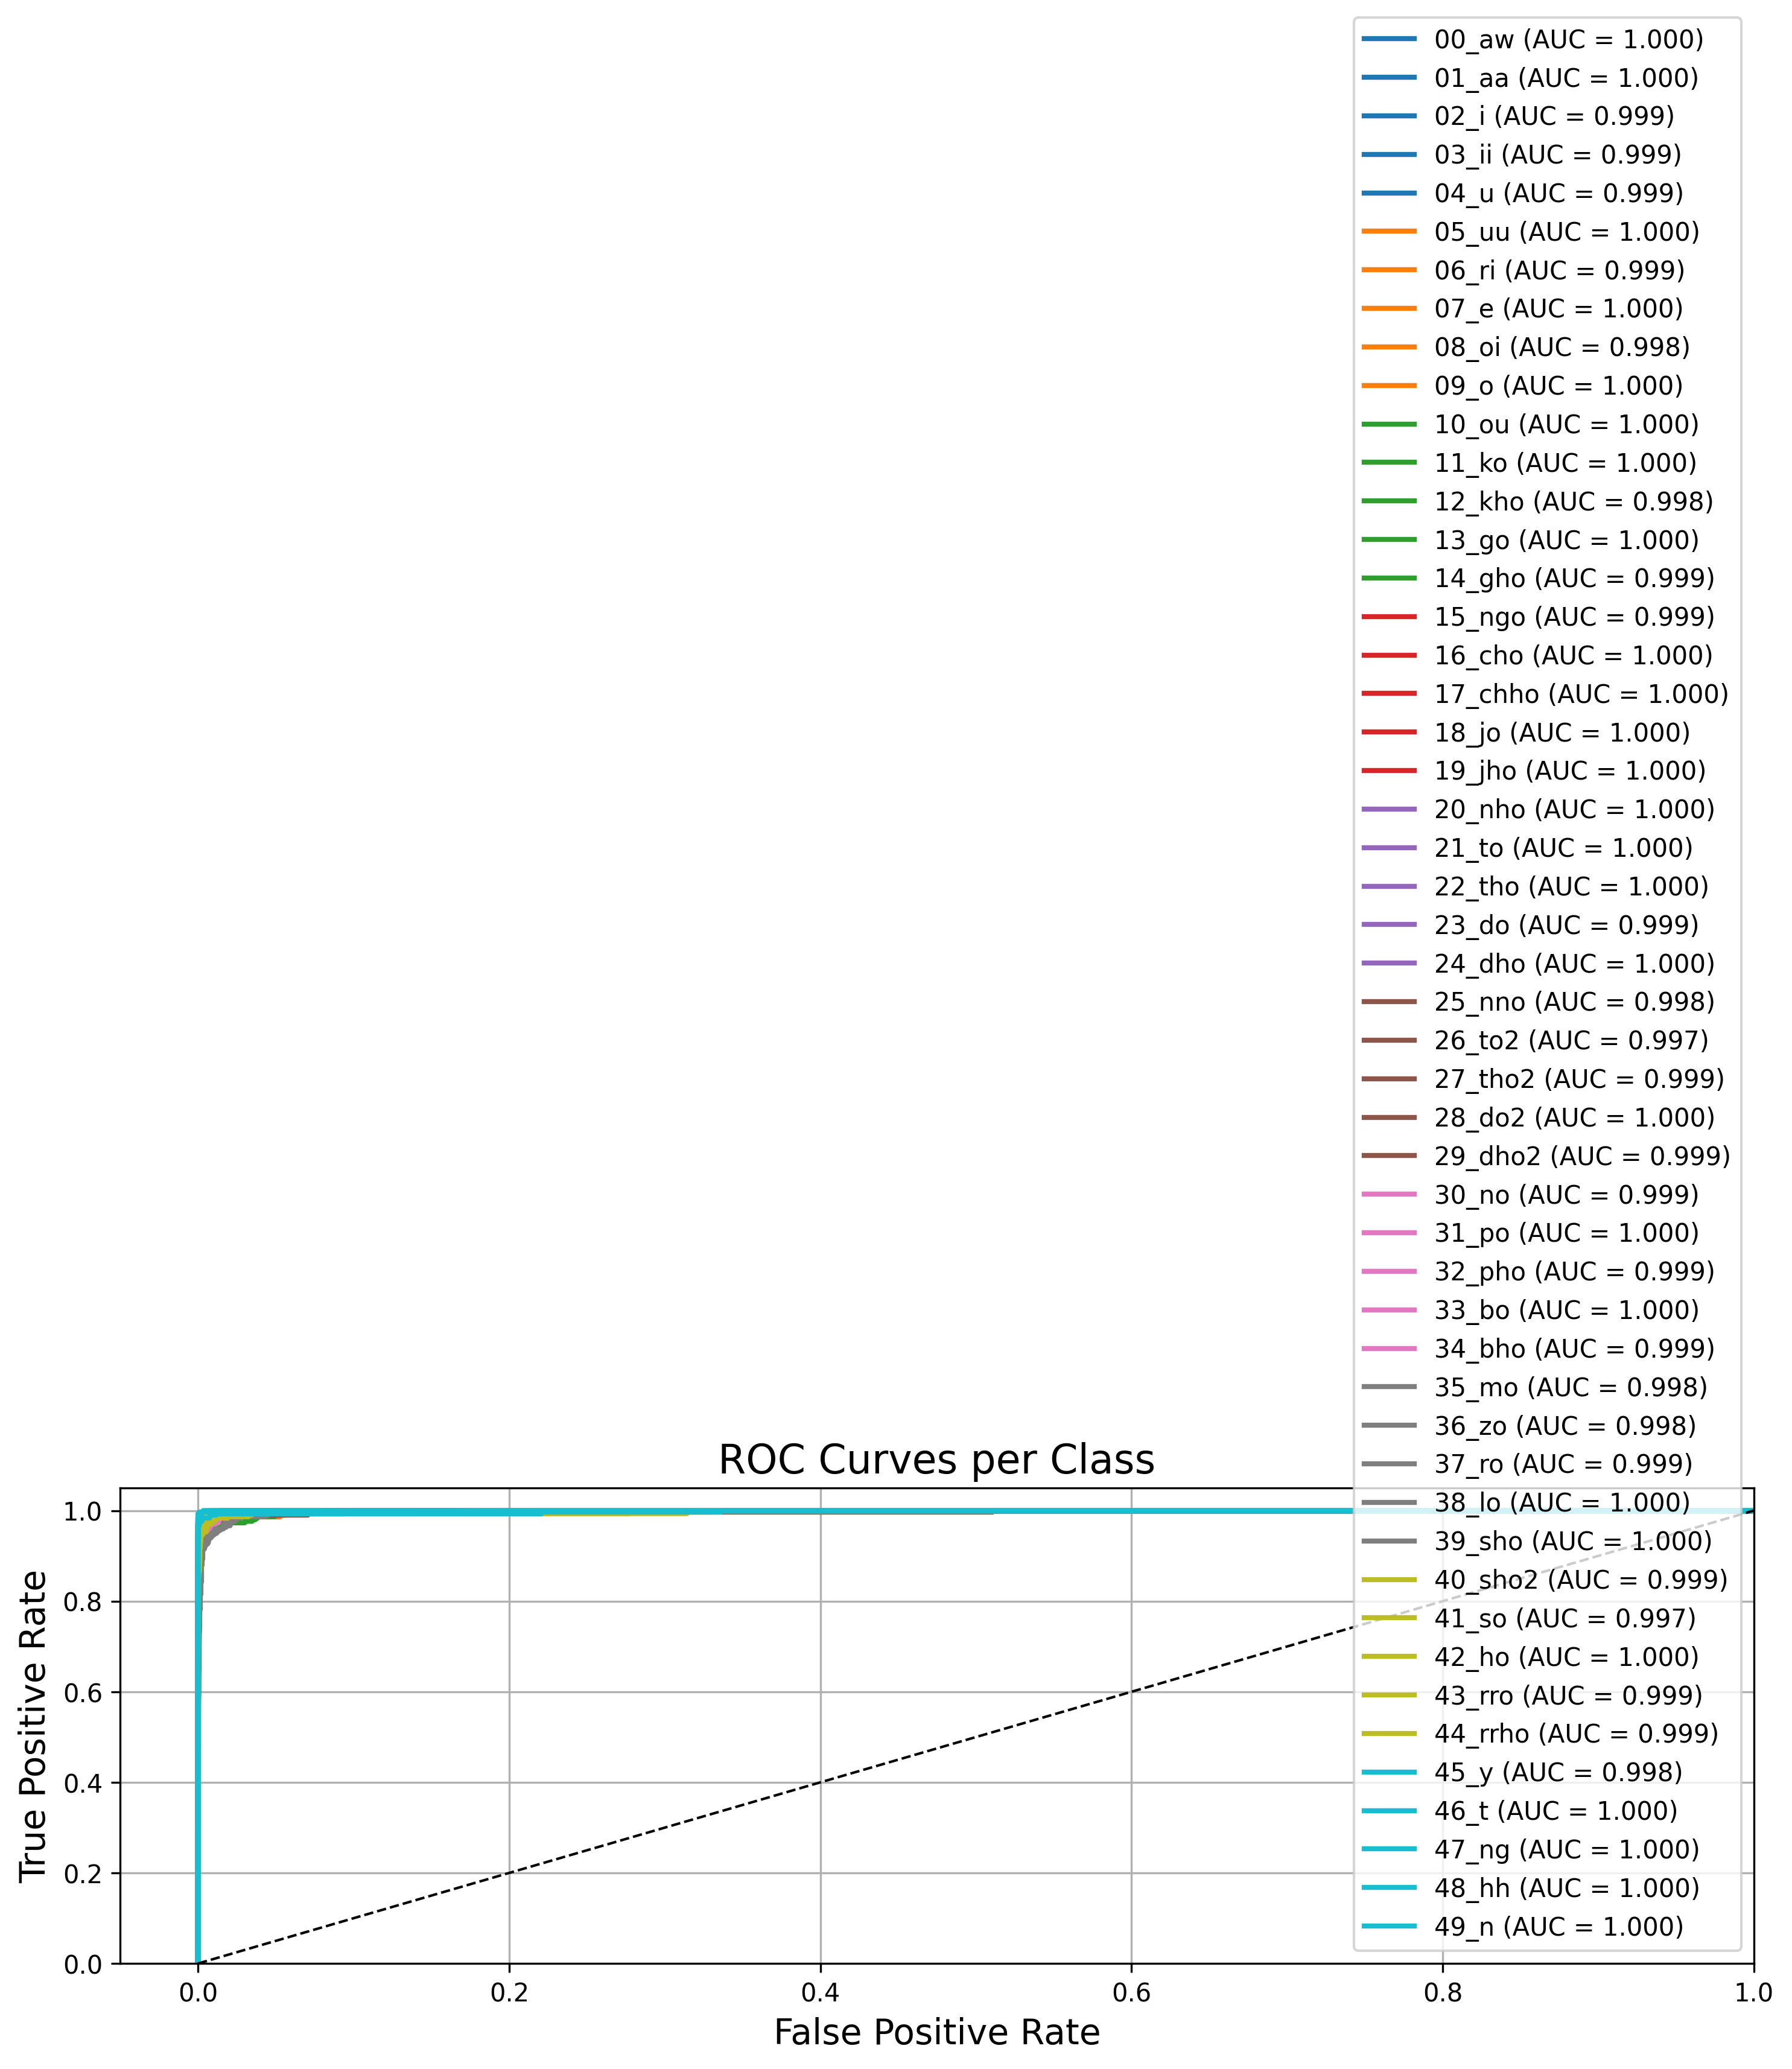

✅ Classification report metrics saved to: metrics.csv


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,       # Higher DPI for better quality
    show_grid=False  # Remove cell lines (default off)
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        # Disable grid & ticks for minor
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150):
    """
    Plot ROC curves for each class (one-vs-rest).

    Parameters:
    - y_true: true labels (integer encoded)
    - y_pred_probs: predicted probabilities (num_samples x num_classes)
    - class_names: list of class names
    - dpi: figure dpi for quality
    """
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(10, 8), dpi=dpi)

    # Colors for the curves
    colors = plt.cm.get_cmap('tab10', num_classes)

    for i in range(num_classes):
        if len(np.unique(y_true_bin[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors(i), lw=2,
                     label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
        else:
            # Class not present in true labels, skip ROC curve
            print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves per Class', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    """
    Generalized evaluation for multi-class classifier with metrics and confusion matrix,
    ROC curve plotting, and export capabilities.

    Parameters:
    - model: keras or sklearn-like model with predict method.
    - test_generator: generator or dataset with .classes and .class_indices attributes.
    - threshold: threshold for ROC-AUC binary decisions (not used here but for reference).
    - plot_cm: bool, whether to plot confusion matrix.
    - normalize_cm: bool, normalize confusion matrix.
    - plot_roc: bool, whether to plot ROC curves.
    - export_metrics_path: str or None, path to save metrics CSV.
    - export_cm_path: str or None, path to save confusion matrix PNG.
    - export_roc_path: str or None, path to save ROC curves PNG.

    Returns:
    - metrics_df: pandas DataFrame with per-class metrics.
    """

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion matrix plot
    if plot_cm:
        # Setup DPI for export or display
        dpi_val = 300 if export_cm_path else 150
        num_classes = len(class_names)
        cell_scale = 0.5
        fig_width = min(25, max(10, num_classes * cell_scale))
        fig_height = min(25, max(10, num_classes * cell_scale))

        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi_val)

        cm = confusion_matrix(y_true, y_pred)
        if normalize_cm:
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm_norm = cm

        im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
        cbar.ax.tick_params(labelsize=10)

        ax.set(
            xticks=np.arange(num_classes),
            yticks=np.arange(num_classes),
            xticklabels=class_names,
            yticklabels=class_names,
            xlabel='Predicted Label',
            ylabel='True Label',
            title="Confusion Matrix"
        )

        tick_font = max(7, 14 - num_classes // 10)
        rotation_angle = 45 if num_classes > 10 else 0
        plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
        plt.setp(ax.get_yticklabels(), fontsize=tick_font)

        # No grid lines as requested
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        fmt = '.2f' if normalize_cm else 'd'
        thresh = cm_norm.max() / 2.
        annotation_font = max(6, 13 - num_classes // 10)
        for i in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                val = format(cm_norm[i, j], fmt)
                ax.text(j, i, val,
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm_norm[i, j] > thresh else "black")

        plt.tight_layout()

        if export_cm_path:
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

        plt.show()

    # 2. Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Macro, Weighted, and Micro Precision, Recall, F1
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            dpi_val_roc = 300 if export_roc_path else 150
            plt.figure(figsize=(10, 8), dpi=dpi_val_roc)
            y_true_bin = label_binarize(y_true, classes=range(num_classes))
            colors = plt.cm.get_cmap('tab10', num_classes)
            for i in range(num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=colors(i), lw=2,
                             label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
                else:
                    print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")
            plt.plot([0, 1], [0, 1], 'k--', lw=1)
            plt.xlim([-0.05, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=14)
            plt.ylabel('True Positive Rate', fontsize=14)
            plt.title('ROC Curves per Class', fontsize=16)
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True)
            plt.tight_layout()
            if export_roc_path:
                plt.savefig(export_roc_path, dpi=dpi_val_roc)
                print(f"✅ ROC curve plot saved to: {export_roc_path}")
            plt.show()
        else:
            print("ROC curve plotting skipped due to mismatch in prediction probabilities dimension.")

    # 5. Export metrics dataframe if path provided
    if export_metrics_path:
        # Prepare metrics DataFrame from classification report
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification report metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }


results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",     # Optional
    export_cm_path="confusion_matrix.png", # Optional
    export_roc_path="roc_curves.png"       # Optional
)
